![wordcloud](wordcloud.png)

As a Data Scientist working for a mobile app company, you usually find yourself applying product analytics to better understand user behavior, uncover patterns, and reveal insights to identify the great and not-so-great features. Recently, the number of negative reviews has increased on Google Play, and as a consequence, the app's rating has been decreasing. The team has requested you to analyze the situation and make sense of the negative reviews.

It's up to you to apply K-means clustering from scikit-learn and NLP techniques through NLTK to sort text data from negative reviews in the Google Play Store into categories!

## The Data

A dataset has been shared with a sample of reviews and their respective scores (from 1 to 5) in the Google Play Store. A summary and preview are provided below.

# reviews.csv

| Column     | Description              |
|------------|--------------------------|
| `'content'` | Content (text) of each review. |
| `'score'` | Score assigned to the review by the user as an integer (from 1 to 5). |

In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import silhouette_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt
import seaborn as sns


In [50]:
# Download necessary files from NLTK:
# punkt -> Tokenization
# stopwords -> Stop words removal
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
# Load the reviews dataset and preview it
reviews = pd.read_csv("reviews.csv")
reviews.head()

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1


In [52]:
# Create new dataframe of negative reviews
df = reviews.loc[reviews.score <= 2]
df= pd.DataFrame(df["content"].values, columns=["documents"])
random_state = 53

# Transformation
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation and numbers
    tokens = [word for word in tokens if word.isalpha()]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Stem the words
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)


# Apply transformation
df["documents"] = df['documents'].apply(clean_text)

#preview data
df["documents"].head()

0                                      open app anymor
1                    beg refund app month nobodi repli
2    cost premium version approx indian rupe per ye...
3    use keep organ updat made mess thing cud u lea...
4                                     dan birthday oct
Name: documents, dtype: object

In [53]:
# 'documents' as a list of tokenized sentences
sentences = df.documents.values

model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4, seed=random_state)

def document_vector(doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.key_to_index]
    if len(doc) == 0:
        return np.mean(model.wv.vectors, axis=0)
    return np.mean(model.wv[doc], axis=0)

df['document_vectors'] = df['documents'].apply(document_vector)

print(df.document_vectors[:5])

0    [0.014035596, 0.09147671, -0.20040148, -0.1414...
1    [0.019469295, 0.09282953, -0.2434295, -0.17452...
2    [0.011968645, 0.12416684, -0.23870037, -0.1581...
3    [0.022753399, 0.10761969, -0.25295556, -0.1728...
4    [0.02263382, 0.06991199, -0.2757778, -0.201898...
Name: document_vectors, dtype: object


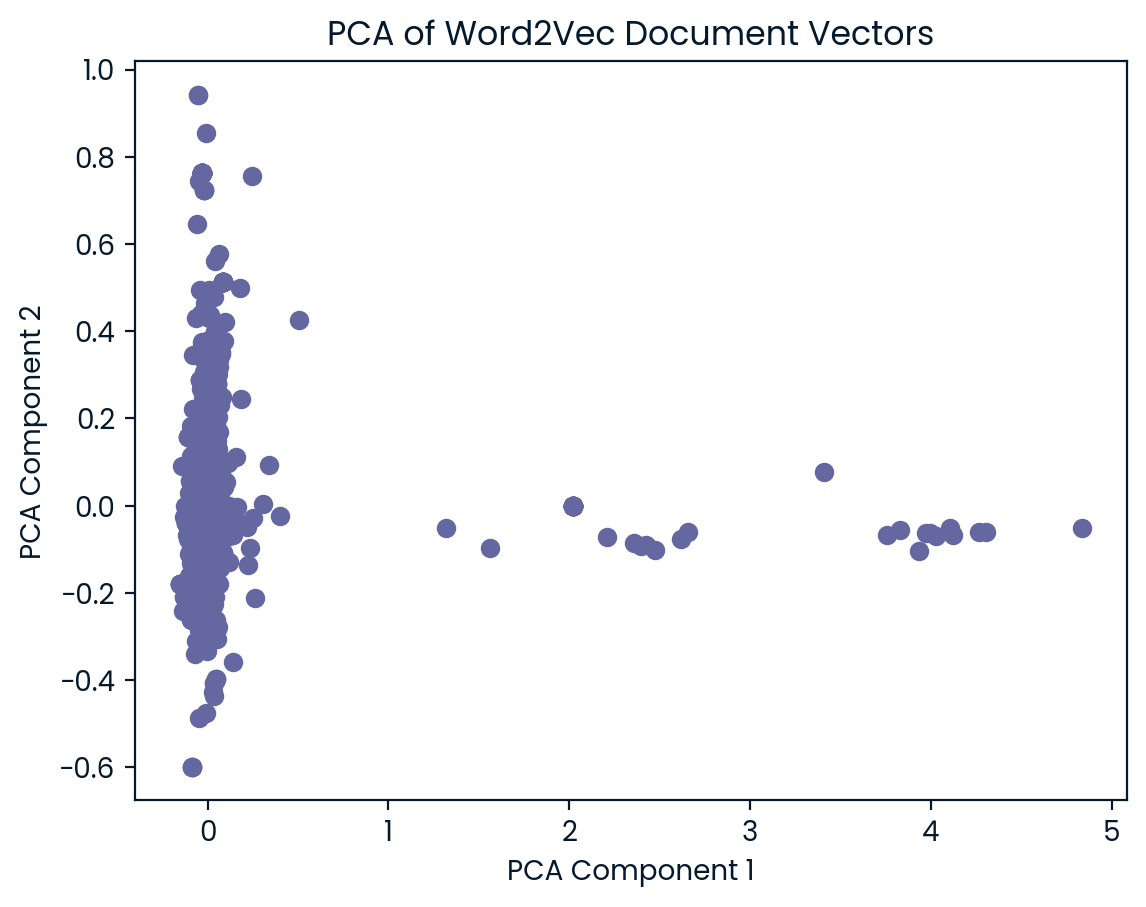

In [54]:

# Convert the list of vectors to a 2D array
X = np.vstack(df['document_vectors'].values)

# Fit the PCA model
pca = PCA(n_components=2, random_state=random_state)
X_train_pca = pca.fit_transform(X)

# Create the scatter plot
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Word2Vec Document Vectors')
plt.show()

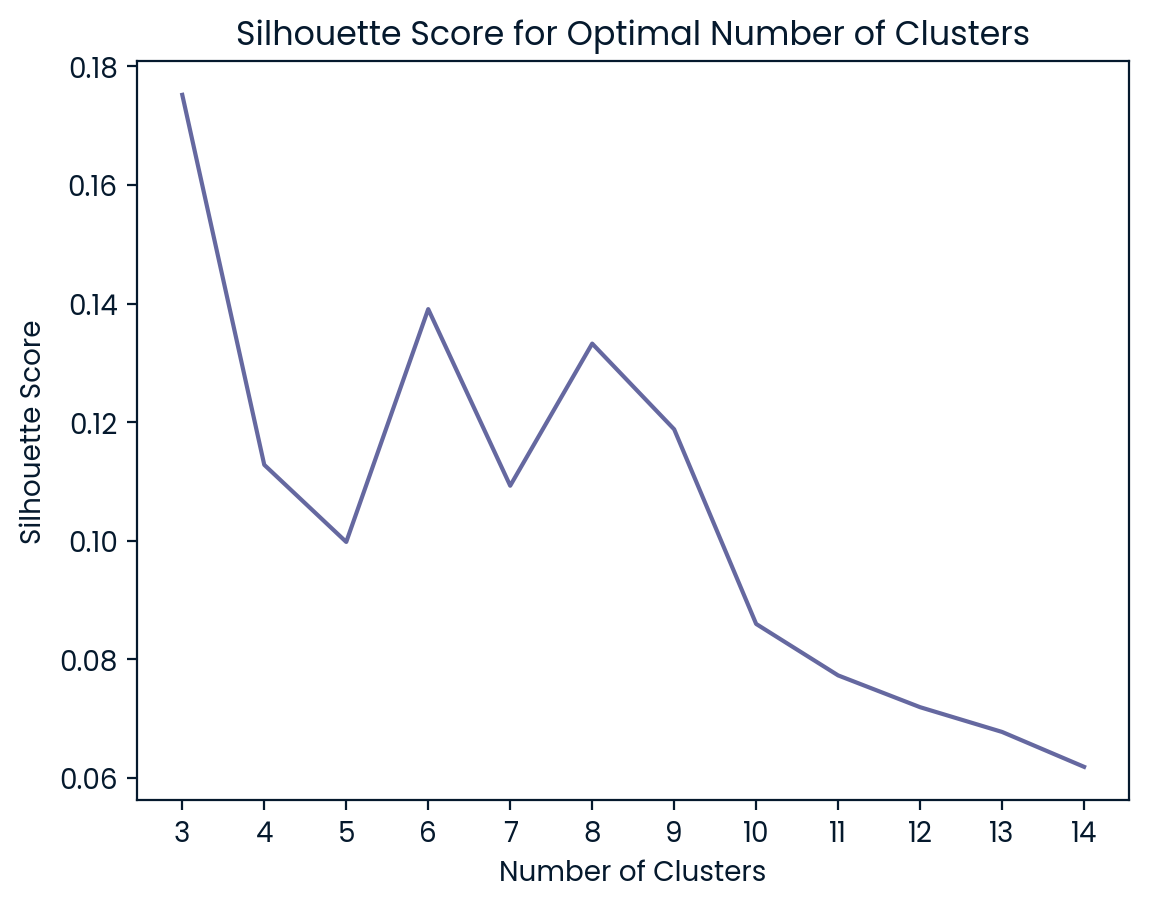

In [55]:

silhouette_scores = []
num_clusters = range(3, 15)
for i in num_clusters:
    centroids, _ = kmeans(X, i, iter=13, thresh=1e-04, seed=random_state)
    cluster_labels, _ = vq(X, centroids)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Create a DataFrame with the number of clusters and silhouette scores
silhouette_plot = pd.DataFrame({'num_clusters': num_clusters, 'silhouette_score': silhouette_scores})

# Create a line plot of num_clusters and silhouette scores
sns.lineplot(x='num_clusters', y='silhouette_score', data=silhouette_plot)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()


In [60]:
# Apply KMeans to cluster the document vectors
num_clusters = 3
kmeans_ = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans_.fit_predict(df['document_vectors'].tolist())

# Apply TF-IDF and NMF to each cluster
num_topics = 3  # Number of topics to extract
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

for cluster in range(num_clusters):
    cluster_docs = df[df['cluster'] == cluster]['documents']
    tfidf_cluster = tfidf_vectorizer.fit_transform(cluster_docs)
    
    nmf = NMF(n_components=num_topics, random_state=random_state)
    nmf.fit(tfidf_cluster)
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf.components_):
        print(f"Cluster {cluster} - Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))


Cluster 0 - Topic #0:
app use calendar task ad time sync like googl updat
Cluster 0 - Topic #1:
remind work notif set task alarm time featur day sound
Cluster 0 - Topic #2:
version premium free pro featur pay paid buy tree purchas
Cluster 1 - Topic #0:
не на же работает это уведомления но то что постоянно
Cluster 1 - Topic #1:
برنامه googl через нет это вас при очень ничего если
Cluster 1 - Topic #2:
приложение что но то при не если очень нет только
Cluster 2 - Topic #0:
good app look use sync job worst pay hard task
Cluster 2 - Topic #1:
bad ad good garbag ok download phone habit crash baad
Cluster 2 - Topic #2:
work widget sync ad idk app googl calendar task wo
